# Control Variate

## Table of Contents
* [1) Sampling at Expiry](#first-bullet)
* [2) Sampling at Exercise](#second-bullet)

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os

# local
from LSM import MonteCarloOptionPricing
from figs import plot_payoffs

## 1) Sampling at Expiry <a class="anchor" id="first-bullet"></a>

In [3]:
# Inputs
dim = 10_000
n = 252
T = 3
σ = 3
K = 100
r = 0.06
S0 = 96
λ = 0.4 # necessary, but only as a placeholder. Parameter does not affect results since we simulate BS!
seed = 8
use_AV = True

# create instance from class
mc_option_pricing = MonteCarloOptionPricing(r, S0, K, T, σ, λ, dim, n, seed, use_AV)

In [4]:
# simulate MC
simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
# Run LSM
mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

(92.48125980170296,
 array([1, 0, 3, ..., 0, 0, 0]),
 array([99.1116424 , 99.46748758,  0.        , ..., 99.09135532,
        98.04392816, 97.54613638]))

In [5]:
# Access and print the payoffs
American_payoffs = mc_option_pricing.payoffs
print("Individual Payoffs:", American_payoffs)

Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0) # European put at expiry
print("Control payoffs:", Control_payoffs)

Individual Payoffs: [99.1116424  99.46748758  0.         ... 99.09135532 98.04392816
 97.54613638]
Control payoffs: [83.52698905 83.52637249  0.         ... 83.52701633 83.52702104
 83.52702114]


Now, the prices (averaging over the previously payoffs)

In [6]:
# Estimate prices by crude Monte Carlo
American_price_est = np.mean(American_payoffs)
Control_price_est = np.mean(Control_payoffs)
print(American_price_est)
print(Control_price_est)
assert len(American_payoffs) == dim and len(Control_payoffs) == dim, "Lengths of American_payoffs and Control_payoffs are not equal to no. of simulations"

98.03296790295121
82.64780024616155


Auxiliary functions

In [7]:
def calculate_theta(american_payoffs, control_payoffs):
    return -np.cov(american_payoffs, control_payoffs)[0, 1] / np.var(control_payoffs) # remember to use off-diagonal
 
def calculate_correlation(american_payoffs, control_payoffs):
    return -np.corrcoef(american_payoffs, control_payoffs)[0, 1]

Calculate statistics

In [8]:
# Compute expected mean of European control variate (i.e., BS)
control_mean = mc_option_pricing.BS_option_value('put')

# Calculates Y_i's
θ = calculate_theta(American_payoffs, Control_payoffs)
Y = American_payoffs + θ*(Control_payoffs - control_mean)
ρ = calculate_correlation(American_payoffs, Control_payoffs)
squared_corr = ρ**2
price_estimate = np.mean(Y)
variance_ratio = np.var(American_payoffs) / np.var(Y)
reduction_factor = (1-squared_corr)**(-1)

# Print results
print(f'Correlation Coefficient: {ρ:.2f}')
print(f'Squared Correlation: {squared_corr:.2f}')
print(f'Control Variate Price Estimate: {price_estimate:.2f}')
print(f'Variance Ratio of Payoffs (American/Control Variate): {variance_ratio:.2f}')
print(f"Reduction Factor (1 - \u03C1^2)^(-1): {reduction_factor:.2f}")

Correlation Coefficient: -0.85
Squared Correlation: 0.73
Control Variate Price Estimate: 98.07
Variance Ratio of Payoffs (American/Control Variate): 3.71
Reduction Factor (1 - ρ^2)^(-1): 3.71


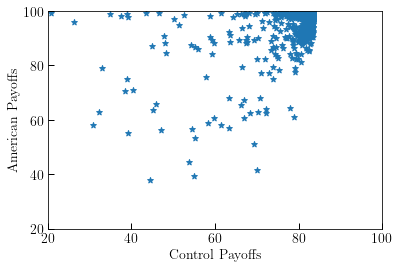

In [9]:
plot_payoffs(American_payoffs, Control_payoffs, x_limits=(20, 100), y_limits=(20, 100))

### Generate Table Values

Running simulation for K=90, σ=1, T=1
Correlation Coefficient: -0.86
Squared Correlation: 0.74
Control Variate Price Estimate: 30.55
Variance Ratio of Payoffs (American/Control Variate): 3.88
Reduction Factor (1 - ρ^2)^(-1): 3.88


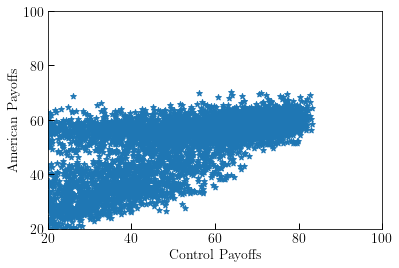

Running simulation for K=90, σ=1, T=2
Correlation Coefficient: -0.86
Squared Correlation: 0.74
Control Variate Price Estimate: 42.34
Variance Ratio of Payoffs (American/Control Variate): 3.84
Reduction Factor (1 - ρ^2)^(-1): 3.84


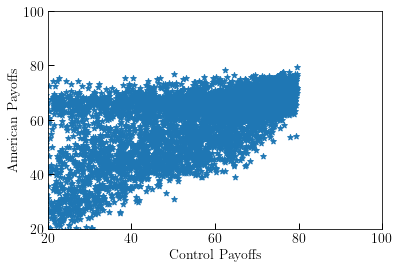

Running simulation for K=90, σ=1, T=3
Correlation Coefficient: -0.87
Squared Correlation: 0.75
Control Variate Price Estimate: 50.28
Variance Ratio of Payoffs (American/Control Variate): 3.97
Reduction Factor (1 - ρ^2)^(-1): 3.97


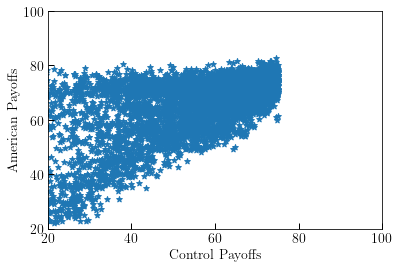

Running simulation for K=90, σ=2, T=1
Correlation Coefficient: -0.91
Squared Correlation: 0.84
Control Variate Price Estimate: 58.73
Variance Ratio of Payoffs (American/Control Variate): 6.07
Reduction Factor (1 - ρ^2)^(-1): 6.07


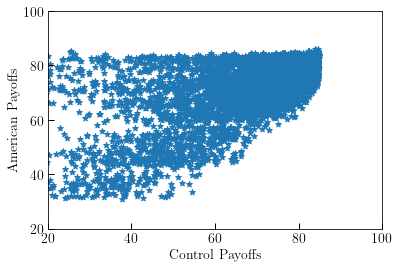

Running simulation for K=90, σ=2, T=2
Correlation Coefficient: -0.88
Squared Correlation: 0.77
Control Variate Price Estimate: 72.98
Variance Ratio of Payoffs (American/Control Variate): 4.44
Reduction Factor (1 - ρ^2)^(-1): 4.44


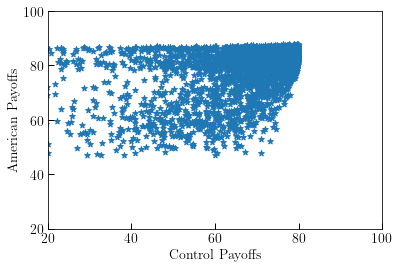

Running simulation for K=90, σ=2, T=3
Correlation Coefficient: -0.88
Squared Correlation: 0.78
Control Variate Price Estimate: 80.31
Variance Ratio of Payoffs (American/Control Variate): 4.55
Reduction Factor (1 - ρ^2)^(-1): 4.55


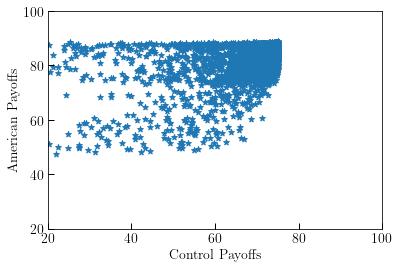

Running simulation for K=100, σ=1, T=1
Correlation Coefficient: -0.85
Squared Correlation: 0.73
Control Variate Price Estimate: 37.16
Variance Ratio of Payoffs (American/Control Variate): 3.71
Reduction Factor (1 - ρ^2)^(-1): 3.71


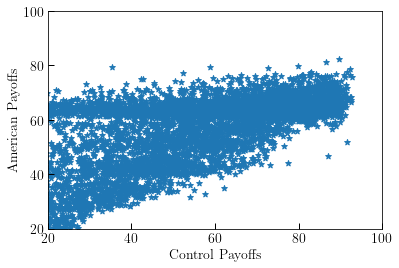

Running simulation for K=100, σ=1, T=2
Correlation Coefficient: -0.86
Squared Correlation: 0.74
Control Variate Price Estimate: 49.57
Variance Ratio of Payoffs (American/Control Variate): 3.79
Reduction Factor (1 - ρ^2)^(-1): 3.79


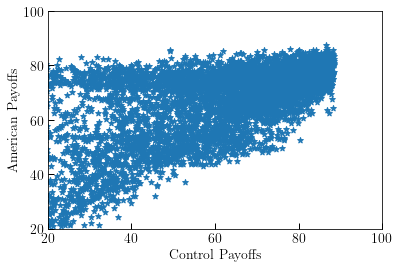

Running simulation for K=100, σ=1, T=3
Correlation Coefficient: -0.85
Squared Correlation: 0.73
Control Variate Price Estimate: 57.81
Variance Ratio of Payoffs (American/Control Variate): 3.72
Reduction Factor (1 - ρ^2)^(-1): 3.72


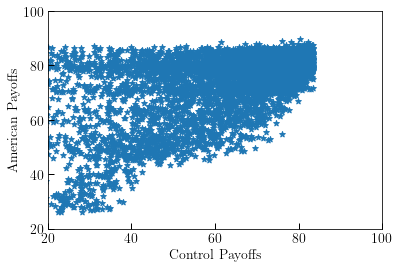

Running simulation for K=100, σ=2, T=1
Correlation Coefficient: -0.91
Squared Correlation: 0.83
Control Variate Price Estimate: 66.84
Variance Ratio of Payoffs (American/Control Variate): 5.81
Reduction Factor (1 - ρ^2)^(-1): 5.81


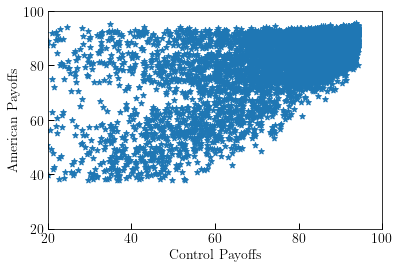

Running simulation for K=100, σ=2, T=2
Correlation Coefficient: -0.88
Squared Correlation: 0.77
Control Variate Price Estimate: 81.92
Variance Ratio of Payoffs (American/Control Variate): 4.27
Reduction Factor (1 - ρ^2)^(-1): 4.27


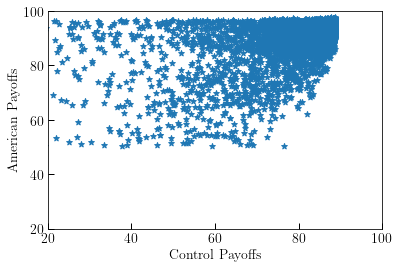

Running simulation for K=100, σ=2, T=3
Correlation Coefficient: -0.88
Squared Correlation: 0.77
Control Variate Price Estimate: 89.74
Variance Ratio of Payoffs (American/Control Variate): 4.33
Reduction Factor (1 - ρ^2)^(-1): 4.33


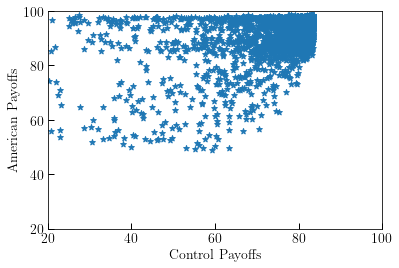

Running simulation for K=110, σ=1, T=1
Correlation Coefficient: -0.85
Squared Correlation: 0.72
Control Variate Price Estimate: 44.35
Variance Ratio of Payoffs (American/Control Variate): 3.53
Reduction Factor (1 - ρ^2)^(-1): 3.53


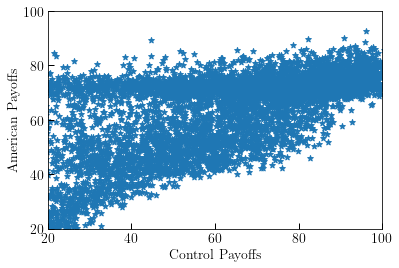

Running simulation for K=110, σ=1, T=2
Correlation Coefficient: -0.85
Squared Correlation: 0.73
Control Variate Price Estimate: 57.08
Variance Ratio of Payoffs (American/Control Variate): 3.68
Reduction Factor (1 - ρ^2)^(-1): 3.68


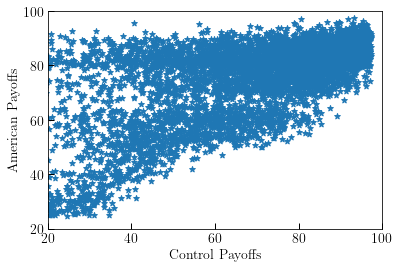

Running simulation for K=110, σ=1, T=3
Correlation Coefficient: -0.85
Squared Correlation: 0.72
Control Variate Price Estimate: 65.70
Variance Ratio of Payoffs (American/Control Variate): 3.59
Reduction Factor (1 - ρ^2)^(-1): 3.59


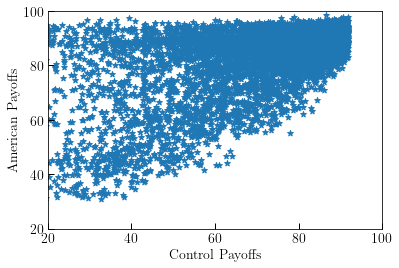

Running simulation for K=110, σ=2, T=1
Correlation Coefficient: -0.90
Squared Correlation: 0.80
Control Variate Price Estimate: 74.85
Variance Ratio of Payoffs (American/Control Variate): 5.11
Reduction Factor (1 - ρ^2)^(-1): 5.11


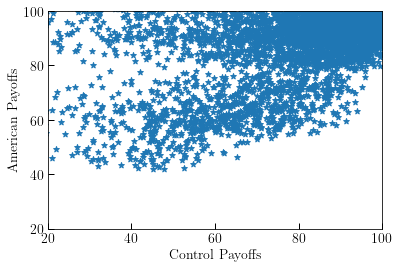

Running simulation for K=110, σ=2, T=2
Correlation Coefficient: -0.87
Squared Correlation: 0.75
Control Variate Price Estimate: 90.84
Variance Ratio of Payoffs (American/Control Variate): 4.06
Reduction Factor (1 - ρ^2)^(-1): 4.06


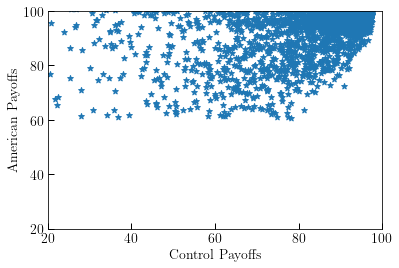

Running simulation for K=110, σ=2, T=3
Correlation Coefficient: -0.88
Squared Correlation: 0.78
Control Variate Price Estimate: 99.26
Variance Ratio of Payoffs (American/Control Variate): 4.54
Reduction Factor (1 - ρ^2)^(-1): 4.54


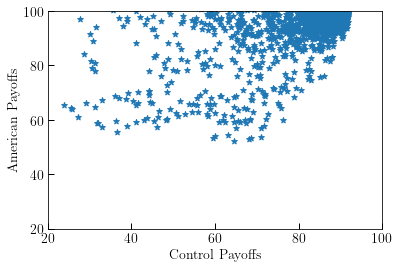

<Figure size 432x288 with 0 Axes>

In [11]:
# Define ranges for K, σ, and T
K_values = [90, 100, 110]
sigma_values = [1, 2]
T_values = [1, 2, 3]

# List to store squared correlations and parameter labels
squared_correlations = []
parameter_labels = []

# Loop over combinations of K, σ, and T
for K in K_values:
    for σ in sigma_values:
        for T in T_values:
            print(f"Running simulation for K={K}, σ={σ}, T={T}")

            # Initialize the Monte Carlo pricer
            mc_option_pricing = MonteCarloOptionPricing(r=0.06, S0=96, K=K, T=T, σ=σ, λ=0.4, dim=10_000, n=252, seed=8, use_AV=True)

            # Simulate GBM and apply the LSM algorithm
            simulated_paths = mc_option_pricing.GeometricBrownianMotion_vec()
            mc_option_pricing.american_option_LSM(poly_degree=3, otype='put')

            # Access and print the payoffs
            American_payoffs = mc_option_pricing.payoffs
            Control_payoffs = np.exp(-r * T) * np.maximum(K - mc_option_pricing.S[:, -1], 0)

            # Estimate prices by crude Monte Carlo
            American_price_est = np.mean(American_payoffs)
            Control_price_est = np.mean(Control_payoffs)
            
            # Compute expected mean of European control variate (i.e., BS)
            control_mean = mc_option_pricing.BS_option_value('put')
            
            # Calculates Y_i's
            θ = calculate_theta(American_payoffs, Control_payoffs)
            Y = American_payoffs + θ*(Control_payoffs - control_mean)
            ρ = calculate_correlation(American_payoffs, Control_payoffs)
            squared_corr = ρ**2
            price_estimate = np.mean(Y)
            variance_ratio = np.var(American_payoffs) / np.var(Y)
            reduction_factor = (1-squared_corr)**(-1)

            # Print results
            print(f'Correlation Coefficient: {ρ:.2f}')
            print(f'Squared Correlation: {squared_corr:.2f}')
            print(f'Control Variate Price Estimate: {price_estimate:.2f}')
            print(f'Variance Ratio of Payoffs (American/Control Variate): {variance_ratio:.2f}')
            print(f"Reduction Factor (1 - \u03C1^2)^(-1): {reduction_factor:.2f}")
           
            # Plot payoffs for correlation
            plot_payoffs(American_payoffs, Control_payoffs, x_limits=(20, 100), y_limits=(20, 100))

            # Clear the plot for the next iteration
            plt.clf()
            
            # Store the squared correlation and parameter label
            parameter_label = f"{K}/{σ}/{T}"
            squared_correlations.append(squared_corr)
            parameter_labels.append(parameter_label)

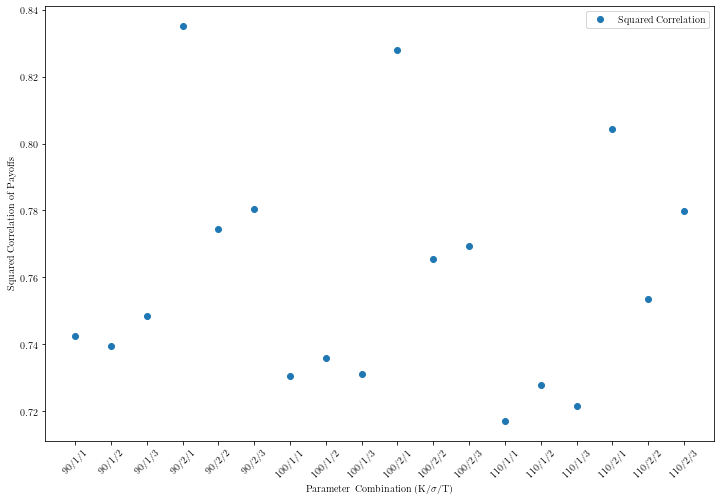

In [23]:
# Plot squared correlations against parameter combinations
plt.figure(figsize=(12, 8))
plt.plot(parameter_labels, squared_correlations, 'o', label='Squared Correlation')
plt.xlabel(r'Parameter Combination (K/$\sigma$/T)')
plt.ylabel('Squared Correlation of Payoffs')
#plt.title('Squared Correlation of Payoffs for Different Option Parameters')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## 2) Sampling at Exercise <a class="anchor" id="second-bullet"></a>